# EfficientDet

In this Notebook we'll be using a EfficientDet model to detect different block texts. We'll use IceVision, an Agnostic Object Detection Framework.

The first thing we need to do is to install the libraries.

## Libraries

### IceVision

In [1]:
%%capture
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

You need to restart the execution environment:

In [ ]:
import os
os.kill(os.getpid(), 9)

In [30]:
from fastai.vision.all import *

In [31]:
from icevision.all import *

### Trained model

In [3]:
%%capture
!wget https://www.dropbox.com/s/acm8u1w5t3dx0du/modelEfficientDet_14.pth?dl=1 -O modelEfficientDet_14.pth

## Dataset

Once we are done with the installation, we load the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/). This dataset is a dataset for Text Detection, Optical Character Recognition, Spatial Layout Analysis and Form Understanding. It's made up of 199 fully annotated forms.

In [ ]:
%%capture
!wget https://guillaumejaume.github.io/FUNSD/dataset.zip -O dataset.zip
!unzip dataset.zip

Let's see the structure of this dataset:

In [ ]:
path=Path('dataset')

In [ ]:
path.ls()

(#3) [Path('dataset/testing_data'),Path('dataset/.DS_Store'),Path('dataset/training_data')]

In [ ]:
path_train=path/'training_data'
path_test=path/'testing_data'

In [ ]:
path_train.ls()

(#3) [Path('dataset/training_data/.DS_Store'),Path('dataset/training_data/annotations'),Path('dataset/training_data/images')]

In [ ]:
path_train_img=path_train/'images'
path_train_anot=path_train/'annotations'

In [ ]:
path_train_img.ls()

(#149) [Path('dataset/training_data/images/0011976929.png'),Path('dataset/training_data/images/0060091229.png'),Path('dataset/training_data/images/88547278_88547279.png'),Path('dataset/training_data/images/91939637.png'),Path('dataset/training_data/images/87682908.png'),Path('dataset/training_data/images/92327794.png'),Path('dataset/training_data/images/89368010.png'),Path('dataset/training_data/images/0001209043.png'),Path('dataset/training_data/images/0060262650.png'),Path('dataset/training_data/images/00922237.png')...]

In [ ]:
path_train_anot.ls()

(#149) [Path('dataset/training_data/annotations/00836816.json'),Path('dataset/training_data/annotations/0060068489.json'),Path('dataset/training_data/annotations/0012529295.json'),Path('dataset/training_data/annotations/80707440_7443.json'),Path('dataset/training_data/annotations/0060025670.json'),Path('dataset/training_data/annotations/0060007216.json'),Path('dataset/training_data/annotations/0001456787.json'),Path('dataset/training_data/annotations/91914407.json'),Path('dataset/training_data/annotations/81310636.json'),Path('dataset/training_data/annotations/91361993.json')...]

In [ ]:
path_test_img=path_test/'images'
path_test_anot=path_test/'annotations'

## Icevision

In order to create and evaluate an IceVision's model, we need to follow the next steps:

1. Create a parser to read the images and annotations
2. Construct the record objects from the parser
3. Define the transforms
4. Create the datasets from the records and augmentations
5. Create the dataloaders from the datasets
6. Define the model
7. Train the model
8. Save the model
9. Inference 






### 1. Parser

In [32]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

IceVision provides a method: `generate_template` which gives us the methods we need to implement in out parser.


In [33]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


Implementation:

In [34]:
import os
import re

In [35]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones,d):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones
        self.class_map=d

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.png")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.png")

    def labels(self, o) -> List[int]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for form in anotacion:
        for j in anotacion[form]:
          label.append(self.class_map.get_name(j['label']))
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for i in anotacion:
        for j in anotacion[i]: # recorre anotacion['form']
          bbox.append(BBox.from_xyxy(j['box'][0],j['box'][1],j['box'][2],j['box'][3]))
      return bbox

We define now the `class_map` which is just an object from the `ClassMap` Class. It contains all the classes of our dataset.

In [36]:
class_map=ClassMap(['question', 'answer', 'header', 'other'])

We define the parser for the training and testing set. 

In [37]:
path

Path('dataset')

In [38]:
parser = AnotacionParser(str(path_train_img), str(path_train_anot),class_map)

In [39]:
parser_test = AnotacionParser(str(path_test_img), str(path_test_anot),class_map)

### 2. Records


In [40]:
train_records, valid_records= parser.parse(RandomSplitter((0.8, 0.2)))

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [41]:
test_records=parser_test.parse(RandomSplitter((1, 0)))

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


### 3. Transforms

The transforms and augmentations are an important part in the construction of the computer visions' models. IceVision includes a library [Albumentations](https://github.com/albumentations-team/albumentations) which provide us a different transformations.

We won't be using any flipping or rotating transformation because of the nature of our dataset. It doesn't make sense to flip or rotate a form, so we'll just normalize the images.


In [49]:
presize = 1024
size = 512

In [50]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

### 4. Dataset

The `Dataset` class is used to combine the records and the tranformations. We will create a dataset for our training set, validation set and testing test.


In [51]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
test_ds = Dataset(test_records, valid_tfms) 

Once we have created all the datasets we can show the images that take part in these datasets. This will help us to visualize and check the transformations we made to the original images.


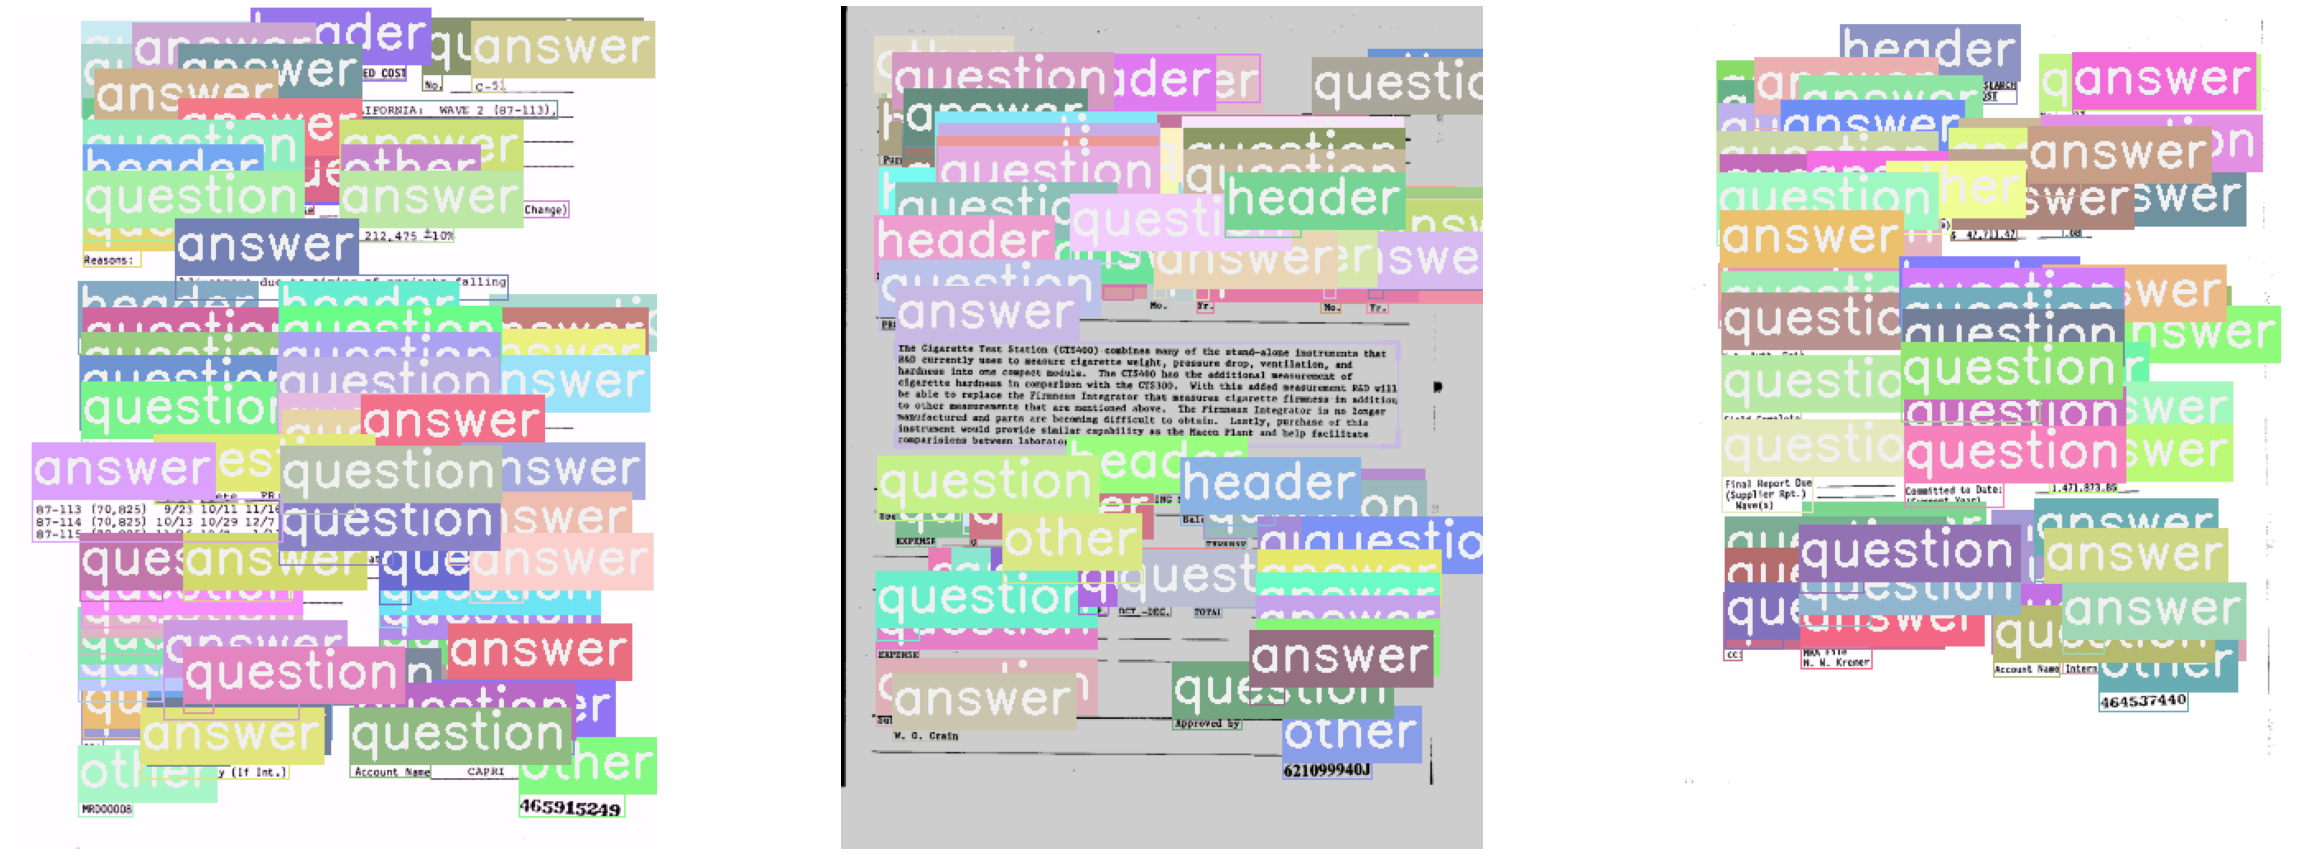

In [52]:
samples = [train_ds[i] for i in range(3)]
show_samples(samples, ncols=3, class_map=class_map,denormalize_fn=denormalize_imagenet)

### 5. DataLoaders

In [53]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)
test_dl = faster_rcnn.valid_dl(test_ds, batch_size=8, num_workers=0, shuffle=False)

### 6. The model

In order to create and train our model we need to create a `Learner` object from FastAI. 
The first thing we need to do is to build the model with the architecture that we want, in this case EfficientNet.

IceVision let us train an EfficientNet model using a backbone by just including its name. In this case we will be using *tf_efficientdet_d3* but there's a bunch of them. 
Feel free to change it:
 
- tf_efficientdet_lite0

- tf_efficientdet_d0

- tf_efficientdet_d1

- tf_efficientdet_d2

- tf_efficientdet_d3

- tf_efficientdet_d4

- tf_efficientdet_d5

- tf_efficientdet_d6

- tf_efficientdet_d7

- tf_efficientdet_d7x

In [55]:
model = efficientdet.model(model_name="tf_efficientdet_d3", num_classes=4, img_size=size)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d3_47-0b525f35.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_d3_47-0b525f35.pth


The next thing we need to do is to define the metrics, the callbacks and the Learner:

In [56]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [57]:
callbacks = [EarlyStoppingCallback(patience=3),SaveModelCallback(fname='modelEfficientDet'),ReduceLROnPlateau(patience=2) ]

In [58]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

### 7. Training

In [59]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

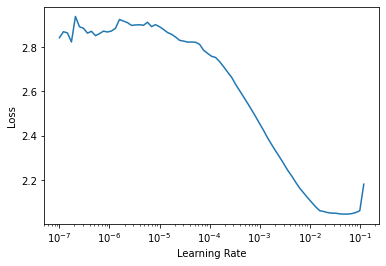

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(500, step, freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.906049,358.520294,0.000000,00:16
1,2.676895,143343.250000,0.000000,00:16


Better model found at epoch 0 with valid_loss value: 358.5202941894531.


epoch,train_loss,valid_loss,COCOMetric,time
0,2.011419,1789.418579,0.000000,00:16
1,1.756471,2275.148682,0.000000,00:17
2,1.571462,5704.978027,0.000000,00:16
3,1.435907,1779.895264,0.000000,00:16
4,1.335971,387.776703,0.000021,00:17
5,1.259089,61.832855,0.000146,00:17
6,1.188744,13.168772,0.000288,00:17
7,1.121358,9.389967,0.001263,00:17
8,1.059880,2.997801,0.002871,00:17
9,1.004582,1.930329,0.004555,00:17


Better model found at epoch 0 with valid_loss value: 1789.4185791015625.
Epoch 2: reducing lr to 0.0012068007458355976
Better model found at epoch 3 with valid_loss value: 1779.895263671875.
Better model found at epoch 4 with valid_loss value: 387.7767028808594.
Better model found at epoch 5 with valid_loss value: 61.832855224609375.
Better model found at epoch 6 with valid_loss value: 13.168771743774414.
Better model found at epoch 7 with valid_loss value: 9.38996696472168.
Better model found at epoch 8 with valid_loss value: 2.997800588607788.
Better model found at epoch 9 with valid_loss value: 1.9303288459777832.
Epoch 11: reducing lr to 0.001276974441135289
Better model found at epoch 12 with valid_loss value: 1.553025245666504.
Better model found at epoch 13 with valid_loss value: 1.3753939867019653.
Better model found at epoch 14 with valid_loss value: 1.230380654335022.
Better model found at epoch 16 with valid_loss value: 1.2224516868591309.
Better model found at epoch 17 with

In [ ]:
learn.save('modelEfficientDet')

Path('/content/drive/MyDrive/ICEVISION/EfficientDet/modelEfficientDet_14.pth.pth')

In [61]:
learn.load('/content/modelEfficientDet_14')

In [62]:
torch.save(model.state_dict(),'modelEfficientDet.pth')

In [ ]:
efficientdet.show_results(model, valid_ds)